In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [26]:
data = pd.read_csv('../dataset/mammographic_masses.data', header=None)
data.columns = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

data = data.replace('?', np.nan)
data = data.dropna()
print(data.shape)

data.head()

(830, 6)


,BI-RADS,Age,Shape,Margin,Density,Severity
0,5,67,3,5,3,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
8,5,57,1,5,3,1
10,5,76,1,4,3,1


In [27]:
data.describe()

,Severity
count,830.000000
mean,0.485542
std,0.500092
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Benign:  51.45 % of the dataset
Malignant:  48.55 % of the dataset


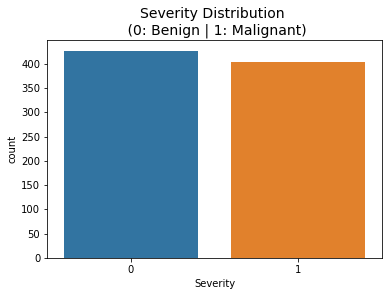

In [35]:
sns.countplot(x='Severity', data=data)
plt.title('Severity Distribution \n (0: Benign | 1: Malignant)', fontsize=14)

print('Benign: ', round(data['Severity'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Malignant: ', round(data['Severity'].value_counts()[1]/len(data) * 100,2), '% of the dataset')


Text(0.5, 1.0, 'Age Distribution')

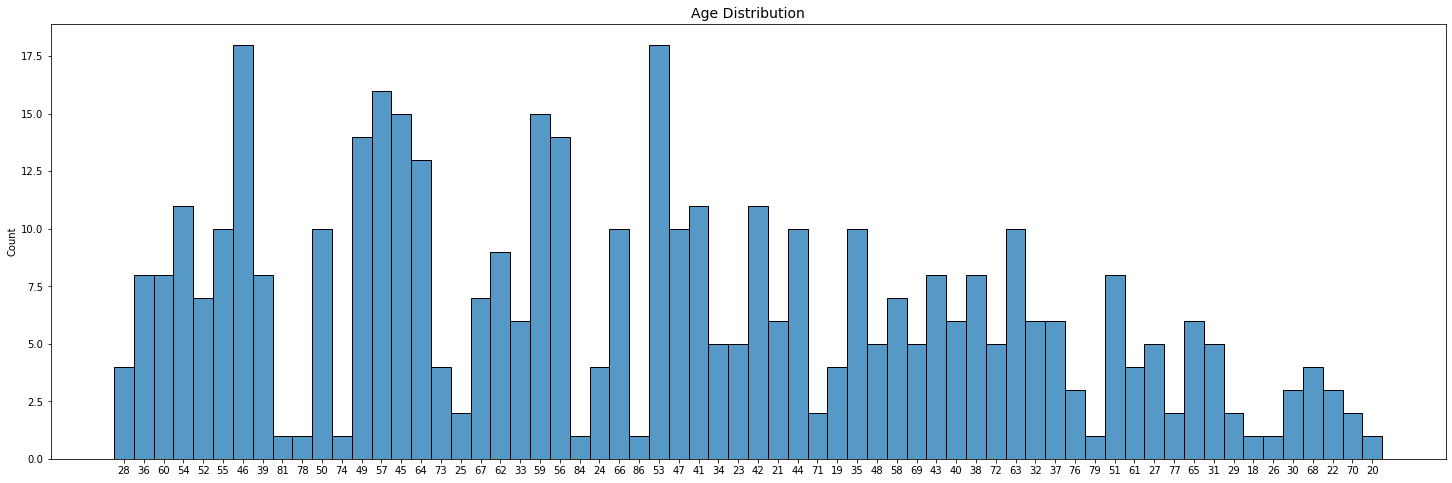

In [50]:
age_benign = data.Age[data.Severity == 0].values


plt.figure(figsize=(25,8))

sns.histplot(age_benign, bins=1)
plt.title('Age Distribution', fontsize=14)

Text(0.5, 1.0, 'Age Distribution')

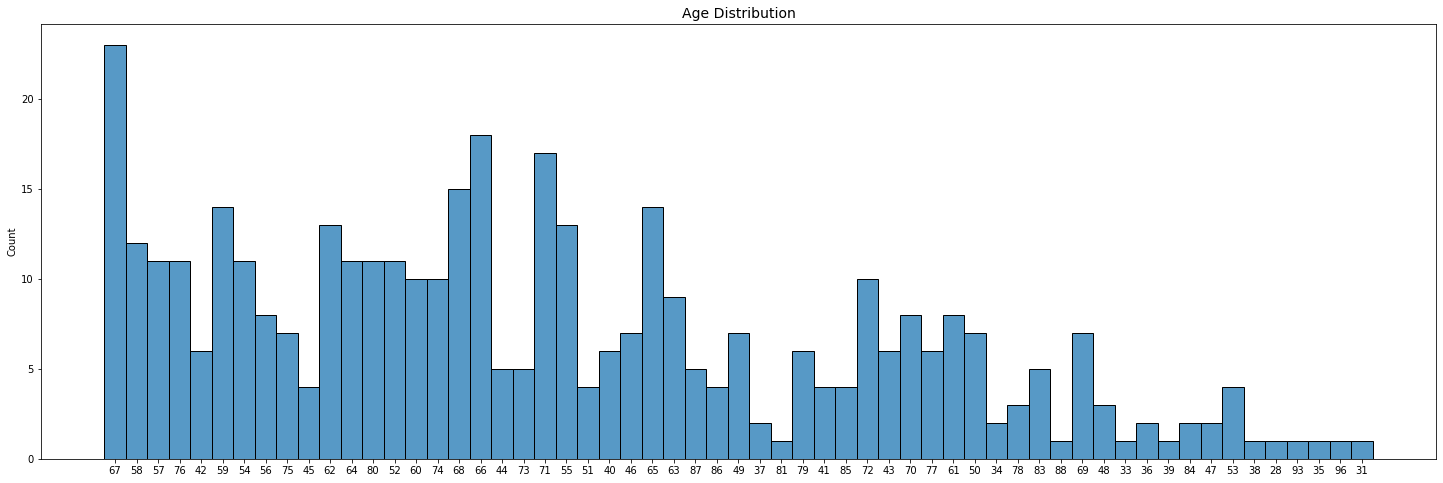

In [51]:
age_malign = data.Age[data.Severity == 1].values


plt.figure(figsize=(25,8))

sns.histplot(age_malign, bins=1)
plt.title('Age Distribution', fontsize=14)